# Current Plan
1. Create a function to calculate the distance between descriptions, use that function to naively classify new descriptions. probably looks something like a search function.
2. Grab a text classification model of hugging face and fine-tune it on the dataset.

In [ ]:
# setup requirements, which aren't loading in the venv for some reason
%pip install -r requirements.txt

## Data Preperation

### Cleaning 
The data is already pretty clean as far as non gramatical structures go. Removing all non-alphanumeric characters and lowercasing actually seems to reduce performance a bit on the embedding model, and these characters are allready stripped in the tokenization process for the naive models.

There are some sanitisation libraries around, eg. pydantic or the NLTK library but i will stick to simple here

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

with open('data/Datas.csv') as file:
    data = pd.read_csv(file)

#over cleaning the data hurts prerformance 
# Strip non alphanumeric characters and convert to lowercase
data['Description'] = data['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
data['Description'] = data['Description'].apply(lambda x: x.lower())

# 
data['Description'] = data['Description'].apply(lambda x: re.sub(r'&amp;', 'and', x))
data['Description'] = data['Description'].apply(lambda x: re.sub(r' & ', 'and', x))

#honestly it should all just get lost in the sauce 

# Change all Categories other than Food and Entertainment to Other
#data['Category'] = ['Other' if category not in ['Food', 'Entertainment'] else category for category in data['Category']]


#save to csv 
data.to_csv('data/cleaned_data.csv', index=False)


### Augmentation/Expansion

#### Sampling and splitting
Oversampling using a target minimum number of samples doesn't seem to work atm, but I'm out of time to debug it.
Smote and AdaSynth are used for the embedded models further down, but they required some extra data to be sythesised to work well.
having never done text generation in this way, I'm following [this guide](https://python.langchain.com/docs/modules/model_io/output_parsers/types/pydantic)

In [14]:
# Split the training set into train, test and val sets
from sklearn.model_selection import train_test_split
# class must have at least 3 samples to be split
tmp = data.groupby('Category').filter(lambda x: len(x) <= 2)
data = data.groupby('Category').filter(lambda x: len(x) > 2)
train, test = train_test_split(data, test_size=0.2, stratify=data['Category'], random_state=42)
#test = pd.concat([test, tmp], axis=0)
train, val = train_test_split(train, test_size=0.3, stratify=train['Category'], random_state=77)

#### Sythesising Data using models
[using the guide](https://python.langchain.com/docs/modules/model_io/output_parsers/types/pydantic)

In [ ]:
# MiniMA 3B model - requires cloud hosting
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer

# MiniMA
tokenizer = AutoTokenizer.from_pretrained("GeneZC/MiniMA-3B", use_fast=False)
# GPU.
model = AutoModelForCausalLM.from_pretrained("GeneZC/MiniMA-3B", use_cache=True, device_map="auto", torch_dtype=torch.float16).eval()
# CPU.
#model = AutoModelForCausalLM.from_pretrained("GeneZC/MiniMA-3B", use_cache=True, device_map="cpu", torch_dtype=torch.float16).eval()$
# model.to('cuda')

prompt = "Question: Sherrie tells the truth. Vernell says Sherrie tells the truth. Alexis says Vernell lies. Michaela says Alexis tells the truth. Elanor says Michaela tells the truth. Does Elanor tell the truth?\nAnswer: No\n\nQuestion: Kristian lies. Sherrie says Kristian lies. Delbert says Sherrie lies. Jerry says Delbert tells the truth. Shalonda says Jerry tells the truth. Does Shalonda tell the truth?\nAnswer: No\n\nQuestion: Vina tells the truth. Helene says Vina lies. Kandi says Helene tells the truth. Jamey says Kandi lies. Ka says Jamey lies. Does Ka tell the truth?\nAnswer: No\n\nQuestion: Christie tells the truth. Ka says Christie tells the truth. Delbert says Ka lies. Leda says Delbert tells the truth. Lorine says Leda tells the truth. Does Lorine tell the truth?\nAnswer:"
input_ids = tokenizer([prompt]).input_ids
output_ids = model.generate(
    torch.as_tensor(input_ids).to('cuda'),
    do_sample=True,
    temperature=0.7,
    max_new_tokens=1024,
)
output_ids = output_ids[0][len(input_ids[0]):]
output = tokenizer.decode(output_ids, skip_special_tokens=True).strip()

In [ ]:
# Define data structure for a row in the dataset.
from typing import List

from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator


class Row(BaseModel):
    Description: str = Field(description="The description of the item")
    Category: str = Field(description="The category of the item")
    SubCategory: str = Field(description="The subcategory of the item")

def sythesise_sample(chain, samples: List[Row]):
    # And a query intented to prompt a language model to populate the data structure.
    sample_rows = "TBC"
    row_query = "generate a sample row for the dataset. \n you can use the following categories: \n" + "\n".join(data['Category'].unique()) 
    row_query = row_query + "\n you can use the following subcategories: \n" + "\n".join(data['SubCategory'].unique())
    row_query = row_query + "\n" + "here are some rows from the dataset: \n" + "\n".join(sample_rows)
    return chain.invoke({"query": row_query}) # not sure how this outputs as I haven't run it yet
    

# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Row)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser

sythesise_sample(chain, Row(Description="TBC", Category="TBC", SubCategory="TBC"))




In [53]:
# generate samples for classes with less than 0.1 proportion of the major class
target_proportion = 0.1
major_class_counts = data['Category'].value_counts().max() # 135
target_count = int(major_class_counts*target_proportion) # 13

new_data = pd.DataFrame(columns=['Description', 'Category', 'SubCategory'])
for category in data['Category'].unique():
    category_data = data[data['Category'] == category]
    # sythesise samples
    i = target_count - len(category_data) 
    while i > 0:
        # use list comprehension to convert dataframe to list of Row objects
        samples = data[data['Category'] == category]
        samples = [Row(Description=sample['Description'], Category=sample['Category'], SubCategory=sample['SubCategory']) for index, sample in samples.iterrows()]
        # append sythesised samples to new_data
        new_data = new_data.append(sythesise_sample(chain, samples)) # not sure if this is right tbh
        i -= 1
    

#### Sampling - NOT IN USE

In [84]:

# Resample the training set
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Oversample, then undersample the training set
# def sample_strategy(df, target_proportion):
#     major_class_counts = df.value_counts().max() # 135
#     target_count = int(major_class_counts*target_proportion) # 13
#     return {k: v if v>target_count else target_count for k, v in train['Category'].value_counts().to_dict().items()}
# # Target a minimum class count of 10% of the majority class

# # targeted oversampling not working
# X_train, y_train = train[['Description']], train['Category']
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
# # oversampler = RandomOverSampler(sampling_strategy=sample_strategy(X_train,0.1), random_state=42)
# X_train, y_train = oversampler.fit_resample(train[['Description']], train['Category'])
# # undersampler = RandomUnderSampler(sampling_strategy=sample_strategy(X_train,-0.5), random_state=42)
# # X_train, y_train = undersampler.fit_resample(X_train, y_train)

# # join back because I don't want to refactor the notebook rn
# train = pd.concat([X_train, y_train], axis=1)   
# print(train.shape, val.shape, test.shape)
# # save data
# train.to_csv('data/train.csv', index=False)

(1485, 2) (114, 5) (95, 5)


#### Tokenization

In [12]:
# Function to measure distance 
from sklearn.feature_extraction.text import TfidfVectorizer
# have a think about whether the data needs cleaning

tfidf = TfidfVectorizer() # use token_pattern to remove punctuation if needed
tfidf.fit(train['Description']) # val set not included here 

TfidfVectorizer()

## Evaluation tools

In [15]:
from sklearn.metrics import  confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def evaluate(Y_true, Y_pred, dataset_name="Train"):
    # evaluate using the sklearn functions
    precision = precision_score(Y_true, Y_pred, average='macro') #TP / (TP + FP)
    recall = recall_score(Y_true, Y_pred, average='macro') #TP / (TP + FN)
    f1_macro = f1_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='weighted')
    accuracy = accuracy_score(Y_true, Y_pred) #(TP + TN) / (TP + FP + FN + TN)
    
    # plot
    print(dataset_name," Precision(macro):", precision)
    print(dataset_name," Recall(macro):", recall)
    print(dataset_name," F1 Score(macro):", f1_macro)
    print(dataset_name," F1 Score(weighted):", f1)
    print(dataset_name," Accuracy:", accuracy)
    
def plot_confusion(Y_true, Y_pred, model, fig_name="confusion.png"):
    confusion = confusion_matrix(Y_true, Y_pred)
    disp = ConfusionMatrixDisplay(confusion, display_labels= model.classes_)
    disp.plot(xticks_rotation=90)
    plt.grid(False)
    plt.savefig('analysis/'+fig_name, bbox_inches='tight')
    plt.show()

## 1. Basic SciKitLearn Models

### Investigating cosine similarity

In [37]:
# cosine distance
from sklearn.metrics.pairwise import cosine_similarity

values = cosine_similarity(tfidf.transform(train['Description']).toarray(), tfidf.transform(train['Description']).toarray()) # dist() = x.y / (||x|| * ||y||) or sum(x * y) / (sqrt(sum(x^2)) * sqrt(sum(y^2)))
similarities = pd.DataFrame(values, index=train.index, columns=train.index)

# plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(similarities)

### SKLearn Models
Testing the variety of models, SVM and Naive Bayes worked the best on the raw data, while KNN and RF didn't work as well as expected.
All models suffered from the distibution issue in the datset, only predicting the most common classes (food and entertainment).

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(tfidf.transform(train['Description']).toarray(), train['Category'])

# predict
train_accuracy = cross_val_score(knn, tfidf.transform(train['Description']).toarray(), train['Category'], cv=5, scoring='accuracy')
val_hat = knn.predict(tfidf.transform(val['Description']).toarray())

# evaluate
print("training accuracy:", train_accuracy.mean())
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn.png")

In [ ]:
# SVM
from sklearn.svm import SVC

# prepare data labels to be numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Category'])
train_Y = le.transform(train['Category'])
val_Y = le.transform(val['Category'])

# setup SVM
svm = SVC(kernel='linear')
svm.fit(tfidf.transform(train['Description']).toarray(), train_Y)

# predict
train_accuracy = cross_val_score(svm, tfidf.transform(train['Description']).toarray(), train['Category'], cv=5, scoring='accuracy')
val_hat = svm.predict(tfidf.transform(val['Description']).toarray())

# evaluate
print("training accuracy:", train_accuracy.mean())
evaluate(val_Y, val_hat, "Val")
plot_confusion(val_Y, val_hat, svm, "confusion_matricies/svm.png")

## 2. HuggingFace Models

### Embedding

In [16]:
# MiniLM encoding; full guide: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
import pandas as pd 
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(train['Description'].values)

assert len(embeddings) == train['Description'].count() 

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### SMOTE / ADASYN synthetic oversampling
This method is really promising, and had a big effect when used on the categories with enough data, but there just isn't enough data to make it work well.

In [47]:
# SMOTE - requires more than 6 samples 
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_X, train_y = smote.fit_resample(embeddings, train['Category'])

In [ ]:
# ADASYN - requires more than 6 samples 
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
train_X, train_y = adasyn.fit_resample(embeddings, train['Category'])
train = pd.concat(train_X, train_y, axis=1)   

### Basic Models on Embeddings

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.1456382715613186
Val  Recall(macro): 0.1657754010695187
Val  F1 Score(macro): 0.1531121360908595
Val  F1 Score(weighted): 0.6755142083249586
Val  Accuracy: 0.7543859649122807


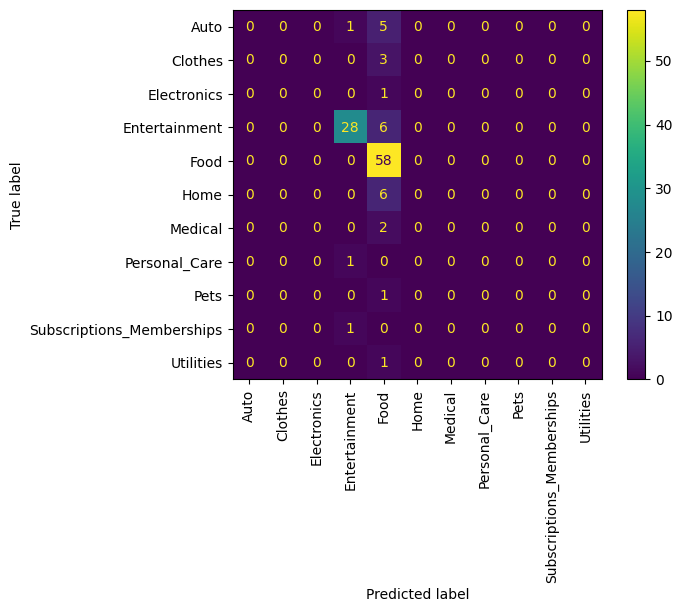

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test  Precision(macro): 0.3354759718396082
Test  Recall(macro): 0.24165120593692022
Test  F1 Score(macro): 0.2588094382560786
Test  F1 Score(weighted): 0.7401095624436587
Test  Accuracy: 0.8


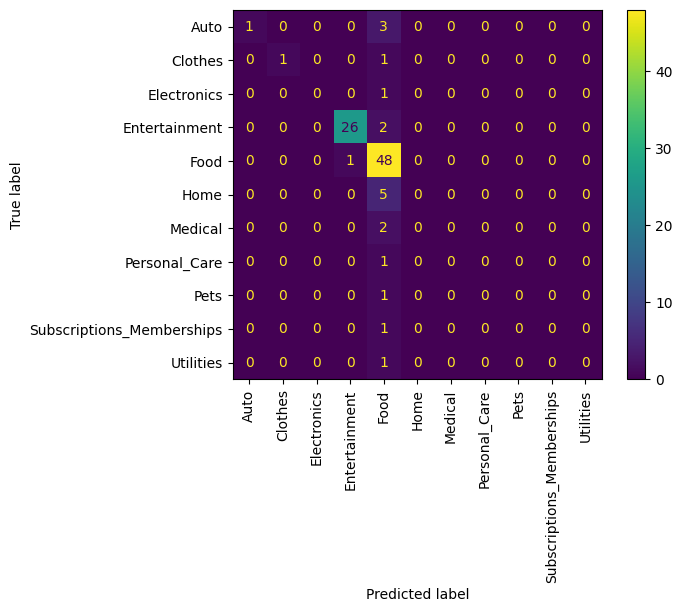

In [51]:
# KNN on embeddings
from sklearn.neighbors import KNeighborsClassifier

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(embeddings, train['Category']) # should still have the same indicies

# predict
train_y_hat = knn.predict(model.encode(train['Description'].values))
val_hat = knn.predict(model.encode(val['Description'].values))
test_hat = knn.predict(model.encode(test['Description'].values))

# evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn_embeddings.png")
evaluate(test['Category'], test_hat, "Test")
plot_confusion(test['Category'], test_hat, knn, "confusion_matricies/knn_embeddings_test.png")

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.23901351174078445
Val  Recall(macro): 0.19005470526768703
Val  F1 Score(macro): 0.18585858585858583
Val  F1 Score(weighted): 0.7173489278752436
Val  Accuracy: 0.7894736842105263


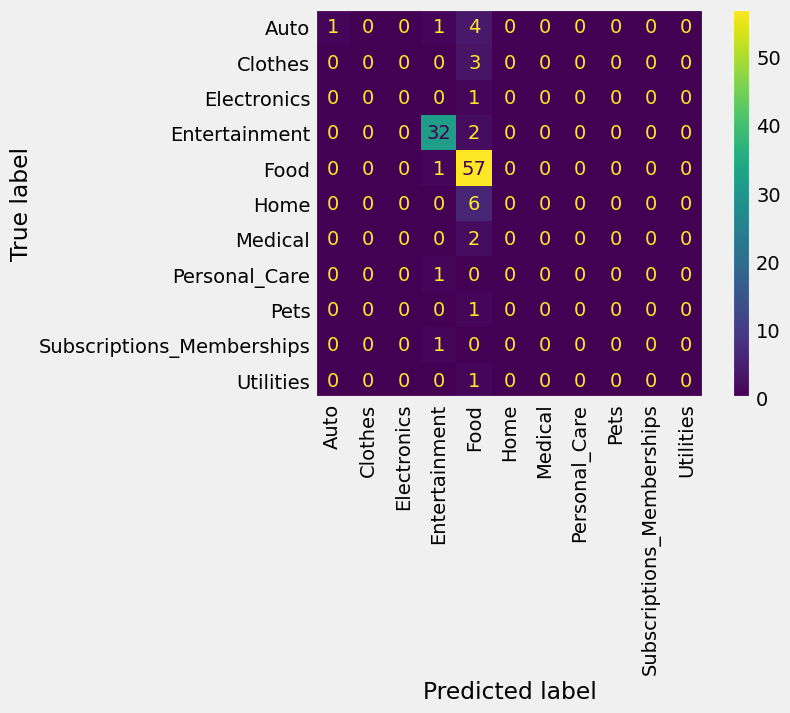

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test  Precision(macro): 0.2912568306010929
Test  Recall(macro): 0.24174397031539885
Test  F1 Score(macro): 0.2520403316641561
Test  F1 Score(weighted): 0.7684468223851164
Test  Accuracy: 0.8210526315789474


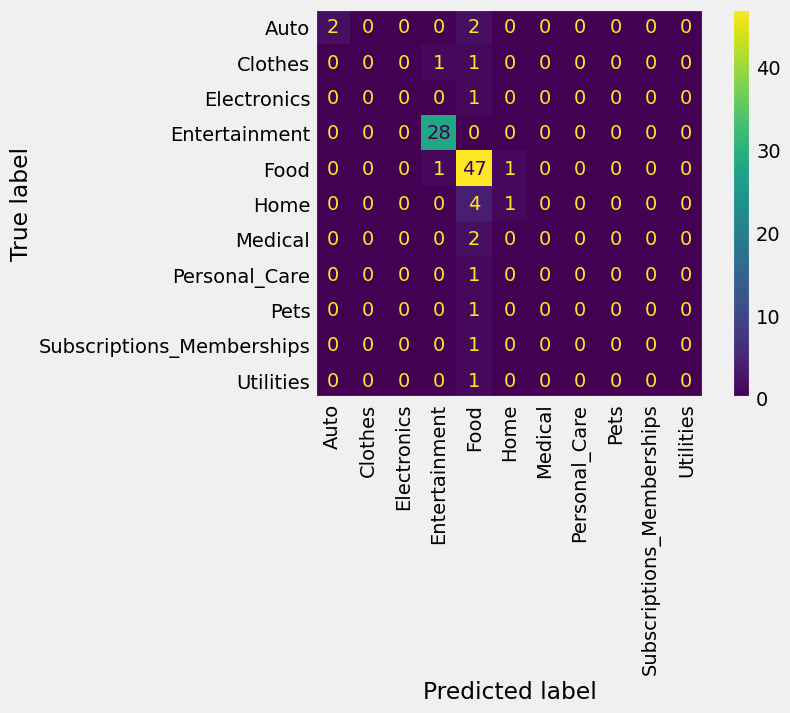

In [57]:
# SVM on embeddings
from sklearn.svm import SVC

# setup SVM
svm = SVC(kernel='linear')
svm.fit(embeddings, train['Category'])

# predict
val_embeddings = model.encode(val['Description'].values)
train_hat = svm.predict(embeddings)
val_hat = svm.predict(val_embeddings)
test_hat = svm.predict(model.encode(test['Description'].values))

# Evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/svm_embeddings.png")
evaluate(test['Category'], test_hat, "Test")
plot_confusion(test['Category'], test_hat, knn, "confusion_matricies/svm_embeddings_test.png")

In [ ]:
# SVM on embeddings subcategories
from sklearn.svm import SVC

# prepare data labels to be numerical
from sklearn.preprocessing import LabelEncoder
cat_le = LabelEncoder()
cat_le.fit(train['Category'])
train_cat = cat_le.transform(train['Category'])
val_cat = cat_le.transform(val['Category'])

subcat_le = LabelEncoder()
# unique values of subcategories
subcats = np.append(train['Sub_Category'].unique(), "Unknown")
subcat_le.fit(subcats)
train_Y = subcat_le.transform(train['Sub_Category'])
val['Sub_Category'] = [subcat if subcat in subcats else "Unknown" for subcat in val['Sub_Category']]
val_Y = subcat_le.transform(val['Sub_Category'])

#concat train_Y to final column in embeddings
#embeddings = np.concatenate((embeddings, train_cat), axis=1)
embeddings = np.column_stack((embeddings, train_cat))
val_embeddings = model.encode(val['Description'].values)
val_embeddings = np.column_stack((val_embeddings, val_cat))

# setup
n_svm = SVC(kernel='linear')
n_svm.fit(embeddings, train_Y)

# predict
train_y_hat = n_svm.predict(embeddings)
val_Y_hat = n_svm.predict(val_embeddings)

# Evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val_Y, val_Y_hat, "Val")
plot_confusion(val_Y, val_Y_hat, n_svm, "confusion_matricies/svm_embeddings_subcategories.png")

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
# SVM with class weights on embeddings
# setup
total = train['Category'].count()
class_weights = {k: 1-(v/total) for k, v in train['Category'].value_counts().to_dict().items()}
svm = SVC(kernel='linear', class_weight=class_weights)
svm.fit(embeddings, train['Category'])

# cross validate
scores = cross_val_score(svm, embeddings, train['Category'], cv=5)

# predict
train_hat = svm.predict(embeddings)
val_embeddings = model.encode(val['Description'].values)
val_hat = svm.predict(val_embeddings)
test_hat = svm.predict(model.encode(test['Description'].values))
# Evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/svm_embeddings_weights.png")
evaluate(test['Category'], test_hat, "Test")
plot_confusion(test['Category'], test_hat, knn, "confusion_matricies/svm_embeddings_test_weights.png")

# Next Steps (post interview activities)

## 3. [AutoEmbedder](https://medium.com/kirey-group/autoembedder-training-embedding-layers-on-unsupervised-tasks-fc364c0f6eec)
Auto Embeddings are a common way to encode categorical features in a machine learning context.
Fasttext also has the added benefit of predicting on subword level features.



In [7]:
# fasttext is nonsense, seems kind of complicated to setup with my existing data cleaning. given I already have passable embeddings, I'm not sure its worth the effort.

CategoryPrediction.ipynb  README.md  analysis/  data/  requirements.txt  venv/


## 4. predicting labels as embeddings
I don't expect this to work well, as I don't know how well I can reproduces embeddings. 

## 5. Using a transformer to classify embeddings

In [25]:
# MiniLM encoding; full guide: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
import pandas as pd 
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
training_embeddings = model.encode(train['Description'].values)
print(training_embeddings.shape) # (n, 384)


assert len(embeddings) == train['Description'].count() 

KeyboardInterrupt: 

In [26]:
# model predicts the category as an embedding
import torch 
import torch.nn as nn
import torch.optim as optim

# Configure the transformer model
# ensure it accepts the embeddings shape (n, 384)
encoder_layer = nn.TransformerEncoderLayer(d_model=384, nhead=8) # 384 dims, 8 attention heads
# encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8) # 512 dims, 8 attention heads
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6, enable_nested_tensor=False) 

# Retrieve the embeddings
training_embeddings = torch.from_numpy(model.encode(train['Description'].values))
target_embeddings = torch.from_numpy(model.encode(train['Category'].values))

# Train the encoder on the training embeddings data
# Define the loss function
criterion = nn.MSELoss()
# Define the optimizer
optimizer = optim.Adam(transformer_encoder.parameters(), lr=0.001)
# Train the model
for epoch in range(100):
    # Forward pass
    output = transformer_encoder(training_embeddings)
    loss = criterion(output, target_embeddings)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print the loss
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))


Epoch [1/100], Loss: 0.9896
Epoch [2/100], Loss: 0.9405
Epoch [3/100], Loss: 0.9245
Epoch [4/100], Loss: 0.9190
Epoch [5/100], Loss: 0.9155
Epoch [6/100], Loss: 0.9122
Epoch [7/100], Loss: 0.9089
Epoch [8/100], Loss: 0.9054
Epoch [9/100], Loss: 0.9023
Epoch [10/100], Loss: 0.8992
Epoch [11/100], Loss: 0.8961
Epoch [12/100], Loss: 0.8929
Epoch [13/100], Loss: 0.8898
Epoch [14/100], Loss: 0.8866
Epoch [15/100], Loss: 0.8833
Epoch [16/100], Loss: 0.8800
Epoch [17/100], Loss: 0.8768
Epoch [18/100], Loss: 0.8736
Epoch [19/100], Loss: 0.8703
Epoch [20/100], Loss: 0.8671
Epoch [21/100], Loss: 0.8638
Epoch [22/100], Loss: 0.8607
Epoch [23/100], Loss: 0.8574
Epoch [24/100], Loss: 0.8542
Epoch [25/100], Loss: 0.8510
Epoch [26/100], Loss: 0.8477
Epoch [27/100], Loss: 0.8446
Epoch [28/100], Loss: 0.8414
Epoch [29/100], Loss: 0.8381
Epoch [30/100], Loss: 0.8350
Epoch [31/100], Loss: 0.8317
Epoch [32/100], Loss: 0.8286
Epoch [33/100], Loss: 0.8253
Epoch [34/100], Loss: 0.8221
Epoch [35/100], Loss: 0

In [78]:
# decoder should be able to convert the embedded categories back to the original categories consistently.
from sklearn.preprocessing import LabelEncoder
# Embed the categories with the model
labels = torch.from_numpy(model.encode(train['Category'].values))
# define lable encoder
le = LabelEncoder()
le.fit(train['Category'])
target_labels = le.transform(train['Category'])

# Define the decoder
cats = len(train['Category'].unique())
decoder = nn.Linear(384, cats) # 384 dims in, 11 out

# train the decoder
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(decoder.parameters(), lr=0.001)
# Train the model
for epoch in range(100):
    # Forward pass
    output = torch.argmax(decoder(labels), dim=1)
    # retrieve predection value from max index
    output = torch.gather(output, 1, output.unsqueeze(1).squeeze())
    loss = criterion(output, target_labels)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print the loss
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


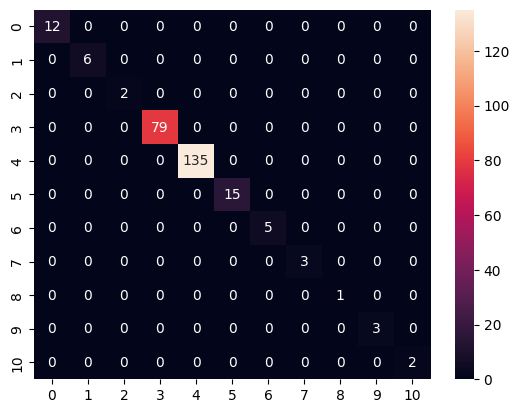

Accuracy: 0.8070175438596491
Precision: 0.33236223236223233
Recall: 0.23283545393078864
F1 Score: 0.2467789127868179


/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


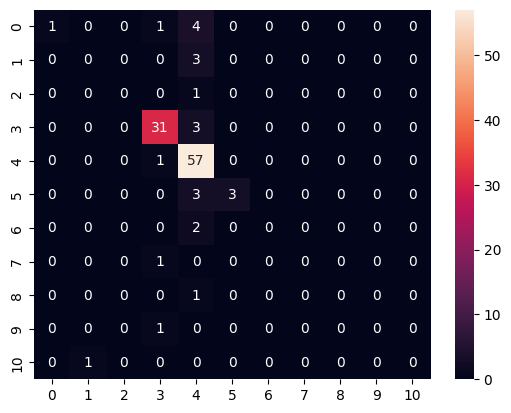

In [68]:
# Evaluate encoder/decoder
# Predict the categories
#predicted_embeddings = transformer_encoder()
predicted_labels = torch.argmax(decoder(training_embeddings), axis=1)
# predicted_labels = torch.argmax(decoder(transformer_encoder(training_embeddings)), axis=1)
# Convert the predicted labels to numpy
predicted_labels = predicted_labels.detach().numpy()
# Convert the predicted labels to categories
predicted_categories = label_encoder.inverse_transform(predicted_labels)

# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(train['Category'], predicted_categories)
print('Accuracy:', accuracy)
print('Precision:', precision_score(train['Category'], predicted_categories, average='macro'))
print('Recall:', recall_score(train['Category'], predicted_categories, average='macro'))
print('F1 Score:', f1_score(train['Category'], predicted_categories, average='macro'))

# confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
confusion = confusion_matrix(train['Category'], predicted_categories)
sns.heatmap(confusion, annot=True, fmt='d')
plt.show()

# Evaluate on the validation set
# Retrieve the embeddings
val_embeddings = torch.from_numpy(model.encode(val['Description'].values))

# Predict the categories
val_predicted_labels = torch.argmax(decoder(val_embeddings), axis=1)
# Convert the predicted labels to numpy
val_predicted_labels = val_predicted_labels.detach().numpy()
# Convert the predicted labels to categories
val_predicted_categories = label_encoder.inverse_transform(val_predicted_labels)

# Evaluate the model
print('Accuracy:', accuracy_score(val['Category'], val_predicted_categories))
print('Precision:', precision_score(val['Category'], val_predicted_categories, average='macro'))
print('Recall:', recall_score(val['Category'], val_predicted_categories, average='macro'))
print('F1 Score:', f1_score(val['Category'], val_predicted_categories, average='macro'))

# confusion matrix
confusion = confusion_matrix(val['Category'], val_predicted_categories)
sns.heatmap(confusion, annot=True, fmt='d')
plt.show()



## Struggling with the core concept really

### Auto encoder
The target for an auto encoder is to reproduce the input, Thus in this context :
X = ['Description'] + ['Category'] + ['Sub_Category']

it's unclear whether I should concatenate the input, or sum the embeddings. My intuition below:
 - I expect that summing the embeddings will result in weird values, eg. a description of a food item might have the same embedding on some axis, which when extended results in something totally different. This could also be a benefit however as it that axis could be the essence of the food category.
 - I expect that summing the embeddings will cause issues when running embeddings without the category data on the test and validation sets. 

based on these expectaions I will start with the simpler concatenation method, and then try the summing method later just in case.

**Alternatively:** 
X = ['Description'] 

If I go this way I would expect that the model will be good at reproducing the Description, maybe even better than the above method, but won't really take advantage of the semantic information stored in the categories and subcategories. 

#### Setting up the autoencoder
Expectations: 
- ReLU is the natural starting point for the activation funciton, as it is has some non-linearities that might help and won't hit any vanishing/exploding gradient issues.
- ReLUs are known to have issues with dead neurons, which is likely here due to sparse data. other options (Leaky ReLU or completely different activation functions) might be worth trying.
- SVM works well in high dimensional spaces, so I don't expect that I will need to reduce down to 30 dims. Starting with a 50% reduction and seeing if there is any improvement is a good starting point.
- Online examples decode with a final Tanh activation, which I would expect to reintroduce the vanishing gradients issue. The advantage is that outputs are forced between -1 and 1 like the input. I'm not really sure if vanishing graidents is made worse the more susceptible layers there are, or if even having one Tanh layer will defeat the purpose of using Relus else where


In [90]:
# Setup autoencoder 
import torch.nn as nn
import torch.optim as optim 
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            # nn.ReLU(True), 
            # nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            # nn.Linear(64, 128),
            # nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True), 
            nn.Linear(256, 384), 
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [69]:
# Train the autoencoder
def train_autoencoder(model, train_X, optimizer,
                        loss = nn.MSELoss(),
                        num_epochs = 100
                    ):

    loss_list = []

    # Training loop 
    for epoch in range(num_epochs):
        # forward pass
        output = model(train_X) # As long as the final feature fits the model input, it will work.
        train_loss = loss(output, train_X)
        
        # backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_list.append(train_loss.item()) 
        
        # Print the loss for every 10 epochs
        if (epoch)%10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}')
            
    # Defining the Plot Style
    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    
    # Plotting the last 100 values
    plt.plot(loss_list[:])

In [123]:
# Evaluate on SVM
from sklearn.svm import SVC
def evaluate_svm(train_X, train_Y, val_X, val_Y):
    #svm = SVC(kernel='rbf', decision_function_shape="ovo")
    svm = SVC(kernel='linear')
    svm.fit(train_X, train_Y)
    train_hat = svm.predict(train_X)
    val_hat = svm.predict(val_X)
    evaluate(train['Category'], train_hat, "Train")
    plot_confusion(train['Category'], train_hat, knn, "confusion_matricies/svm_embeddings.png")
    evaluate(val_Y, val_hat, "Val")
    plot_confusion(val_Y, val_hat, knn, "confusion_matricies/svm_embeddings.png")

In [126]:
# Train the autoencoder
def train_classifier(model, train_X, train_y, optimizer,
                        loss = nn.MSELoss(),
                        num_epochs = 100
                    ):

    loss_list = []

    # Training loop 
    for epoch in range(num_epochs):
        # forward pass
        output = model(train_X) # As long as the final feature fits the model input, it will work.
        train_loss = loss(output, train_y)
        
        # backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_list.append(train_loss.item()) 
        
        # Print the loss for every 10 epochs
        if (epoch)%10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}')
            
    # Defining the Plot Style
    # plt.style.use('fivethirtyeight')
    # plt.xlabel('Iterations')
    # plt.ylabel('Loss')
    
    # # Plotting the last 100 values
    # plt.plot(loss_list[:])

In [128]:
# Evaluate on basic NN
import torch
def evaluate_nn(train_X, train_Y, val_X, val_Y):
    # Define the model
    model = torch.nn.Sequential(
        nn.Linear(384, 256), 
        nn.ReLU(True),
        nn.Linear(256, 128),
        nn.ReLU(True),
        nn.Linear(128, 64),
        nn.ReLU(True),
        nn.Linear(64, 32),
        nn.tahn())
    
    #train the model
    optimizer = optim.Adam(concat_model.parameters(), lr=0.001, weight_decay=1e-5)  # larger the no batches the smaller the weight decay
    train_classifier(model, train_X, train_Y, optimizer)
    

    # Predict the categories
    train_hat = model(train_X)
    val_hat = model(val_X)
    # Evaluate the model
    evaluate(train_Y, train_hat, "Train")
    evaluate(val_Y, val_hat, "Val")

#### Contatenation method

Epoch [1/100], Loss: 0.0044
Epoch [11/100], Loss: 0.0019
Epoch [21/100], Loss: 0.0017
Epoch [31/100], Loss: 0.0015
Epoch [41/100], Loss: 0.0014
Epoch [51/100], Loss: 0.0013
Epoch [61/100], Loss: 0.0013
Epoch [71/100], Loss: 0.0013
Epoch [81/100], Loss: 0.0012
Epoch [91/100], Loss: 0.0012
Validation Loss: 0.0021
Train  Precision(macro): 0.3057692908259724
Train  Recall(macro): 0.3564250095895666
Train  F1 Score(macro): 0.32605456095676644
Train  F1 Score(weighted): 0.8741404332448126
Train  Accuracy: 0.908745247148289


/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


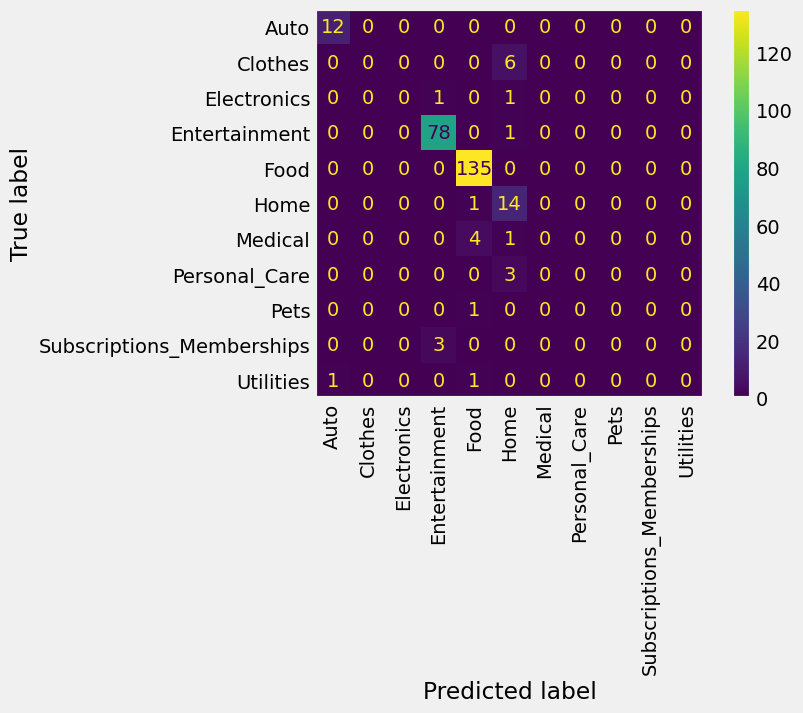

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.26907970735463993
Val  Recall(macro): 0.25235109717868337
Val  F1 Score(macro): 0.23843006279358195
Val  F1 Score(weighted): 0.7136820997600889
Val  Accuracy: 0.7456140350877193


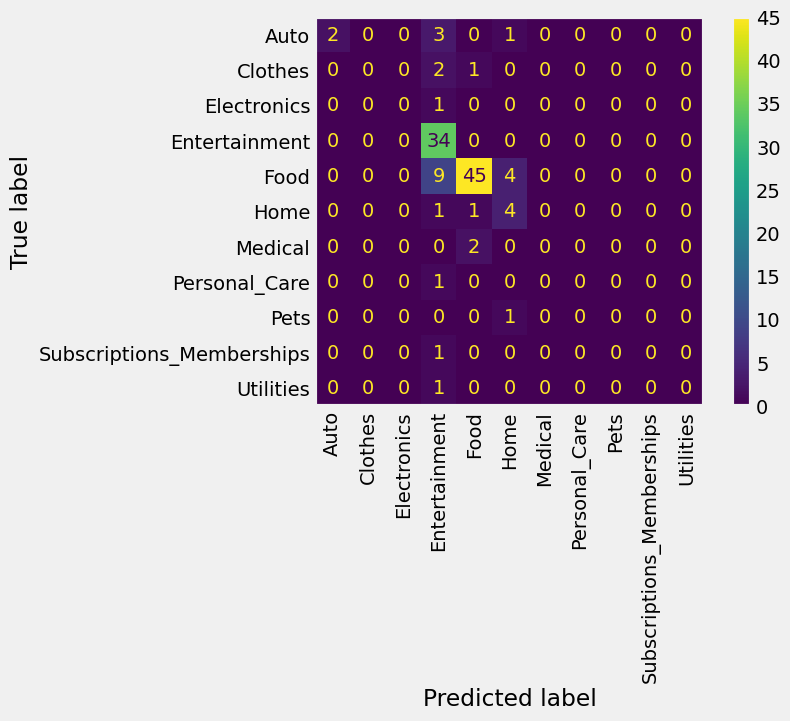

In [124]:
# MiniLM encoding on concatenated data
from torch import from_numpy
train_X = from_numpy(
    model.encode(
        train[['Description', 'Category', 'Sub_Category']].apply(lambda x: ', '.join(x.astype(str)), axis=1).values
        #train[['Description', 'Category']].apply(lambda x: ', '.join(x.astype(str)), axis=1).values
))
val_X = from_numpy(model.encode(val['Description'].values.astype(str))) # don't include the categories in the val or test sets
# test_X = model.encode(test['Description'].values.astype(str))

# Train the autoencoder
concat_model = autoencoder()
optimizer = optim.Adam(concat_model.parameters(), lr=0.001, weight_decay=1e-5)  # larger the no batches the smaller the weight decay
train_autoencoder(concat_model, train_X, optimizer, num_epochs=100)
# Validate the autoencoder
val_outputs = concat_model(val_X)
val_loss = loss(val_outputs, val_X)
print(f'Validation Loss: {val_loss.item():.4f}')

# evaluate
train_X_embedding = concat_model.encoder(train_X).detach().numpy()
val_X_embedding = concat_model.encoder(val_X).detach().numpy()
evaluate_svm(train_X_embedding, train['Category'], val_X_embedding, val['Category'])

#### Summing method

#### Description only method

Epoch [1/100], Loss: 0.0042
Epoch [11/100], Loss: 0.0022
Epoch [21/100], Loss: 0.0022
Epoch [31/100], Loss: 0.0021
Epoch [41/100], Loss: 0.0020
Epoch [51/100], Loss: 0.0019
Epoch [61/100], Loss: 0.0019
Epoch [71/100], Loss: 0.0018
Epoch [81/100], Loss: 0.0017
Epoch [91/100], Loss: 0.0016
Validation Loss: 0.0018
Train  Precision(macro): 0.15086681342872865
Train  Recall(macro): 0.17471764054042535
Train  F1 Score(macro): 0.1609604236484122
Train  F1 Score(weighted): 0.709393661275135
Train  Accuracy: 0.7870722433460076


/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


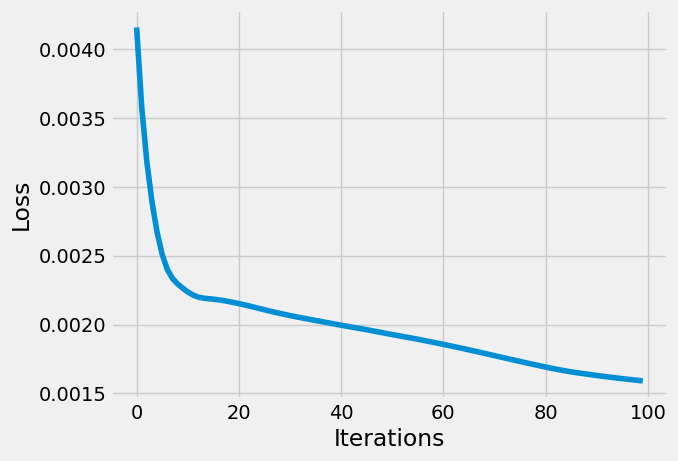

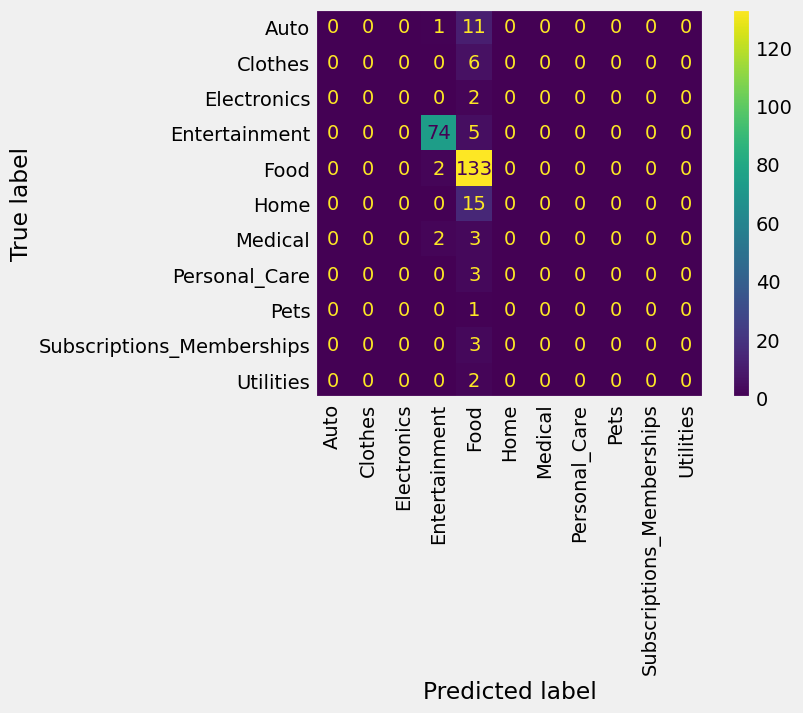

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.14986026631596253
Val  Recall(macro): 0.17647058823529413
Val  F1 Score(macro): 0.16129559639556465
Val  F1 Score(weighted): 0.7074186046943234
Val  Accuracy: 0.7894736842105263


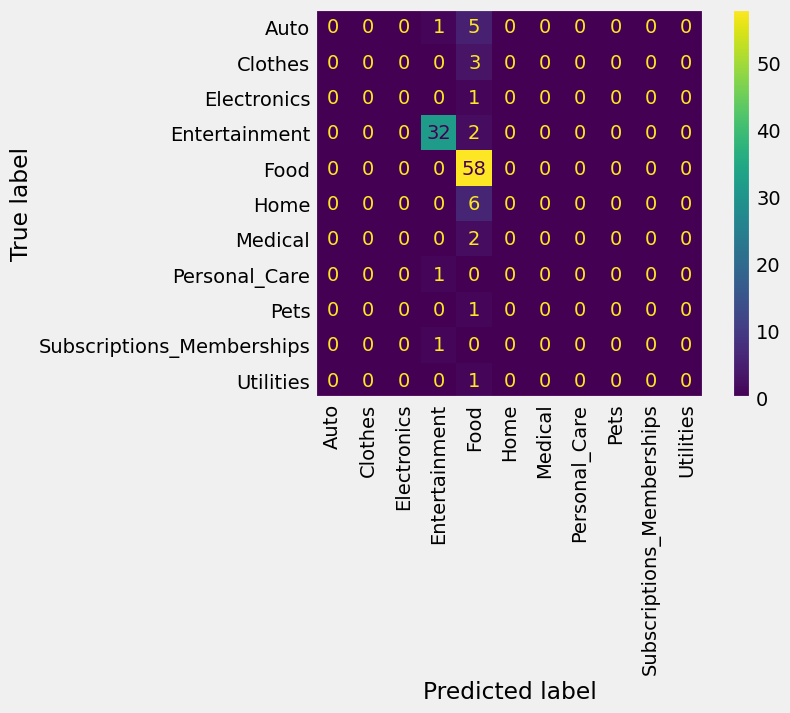

In [56]:
# MiniLM encoding on concatenated data
from torch import from_numpy
train_X = from_numpy(model.encode(train['Description'].values.astype(str)))
val_X = from_numpy(model.encode(val['Description'].values.astype(str))) # don't include the categories in the val or test sets

# Train the autoencoder
desc_only_model = autoencoder()
optimizer = optim.Adam(desc_only_model.parameters(), lr=0.001, weight_decay=1e-5)  # larger the no batches the smaller the weight decay
train_autoencoder(desc_only_model, train_X, optimizer, num_epochs=100)
# Validate the autoencoder
val_outputs = desc_only_model(val_X)
val_loss = loss(val_outputs, val_X)
print(f'Validation Loss: {val_loss.item():.4f}')

evaluate_svm(desc_only_model.encoder(train_X).detach().numpy(), train['Category'], desc_only_model.encoder(val_X).detach().numpy(), val['Category'])

### Encoder based classification


Epoch [1/100], Loss: 0.0040
Epoch [11/100], Loss: 0.0014
Epoch [21/100], Loss: 0.0009
Epoch [31/100], Loss: 0.0005
Epoch [41/100], Loss: 0.0004
Epoch [51/100], Loss: 0.0004
Epoch [61/100], Loss: 0.0003
Epoch [71/100], Loss: 0.0003
Epoch [81/100], Loss: 0.0003
Epoch [91/100], Loss: 0.0003
Validation Loss: 0.0027
Train  Precision(macro): 0.3106358379128778
Train  Recall(macro): 0.36363636363636365
Train  F1 Score(macro): 0.32889172995612204
Train  F1 Score(weighted): 0.8854035773029155
Train  Accuracy: 0.9163498098859315


/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


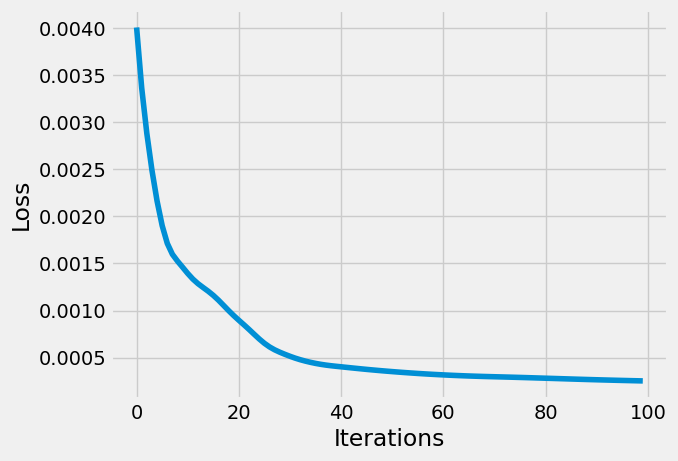

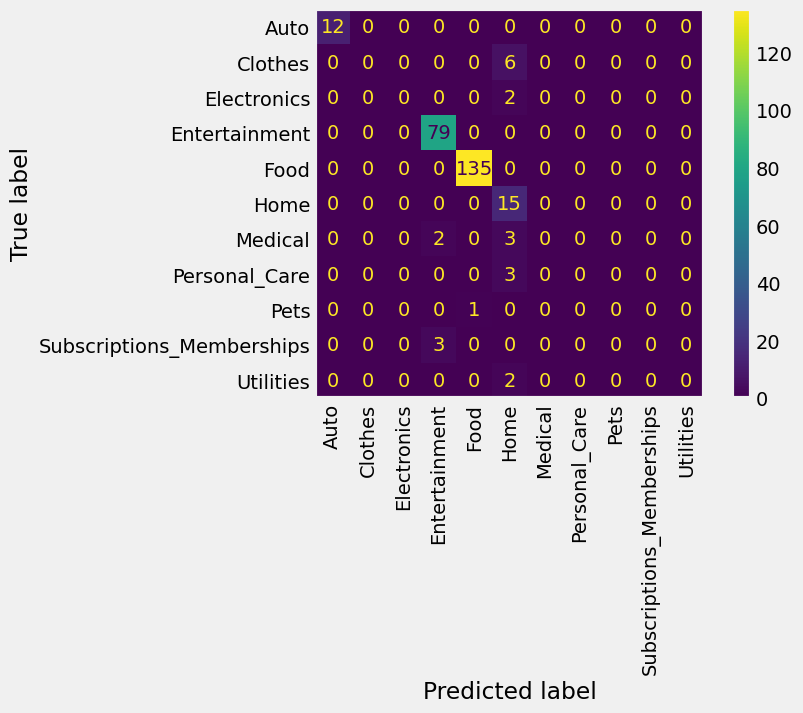

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.25936084987809127
Val  Recall(macro): 0.23667711598746086
Val  F1 Score(macro): 0.1950343377432116
Val  F1 Score(weighted): 0.6562735328201146
Val  Accuracy: 0.6578947368421053


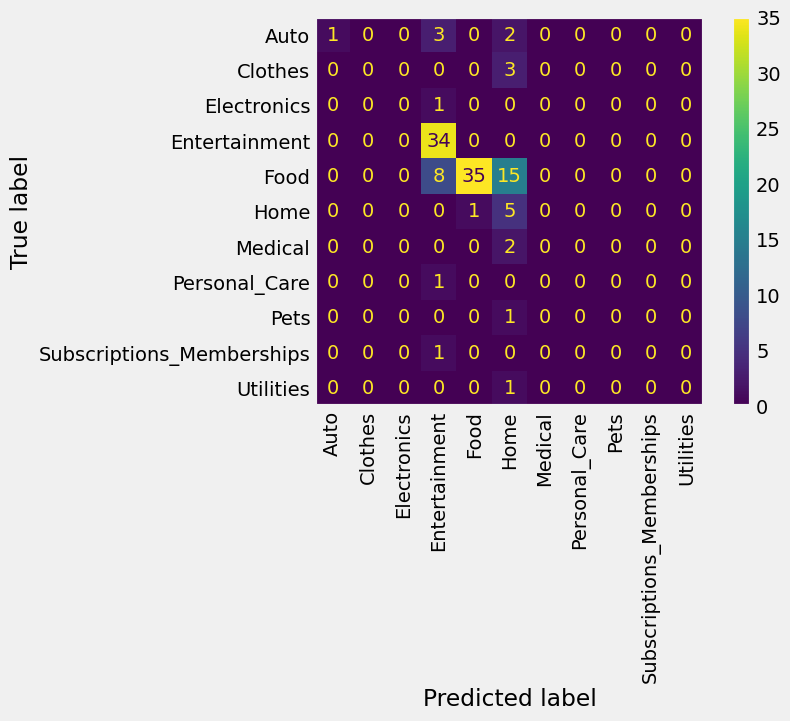

In [83]:
# MiniLM encoding on concatenated data
from torch import from_numpy
train_X = from_numpy(
    model.encode(
        train[['Description', 'Category', 'Sub_Category']].apply(lambda x: ', '.join(x.astype(str)), axis=1).values
))
train_y = from_numpy(model.encode( train[['Category', 'Sub_Category']].apply(lambda x: ', '.join(x.astype(str)), axis=1).values.astype(str)))
val_X = from_numpy(model.encode(val['Description'].values.astype(str))) # don't include the categories in the val or test sets
# test_X = model.encode(test['Description'].values.astype(str))

# Train the autoencoder
classifying_model = autoencoder()
optimizer = optim.Adam(classifying_model.parameters(), lr=0.001, weight_decay=1e-5)  # larger the no batches the smaller the weight decay
#train_autoencoder(classifying_model, train_X, optimizer, num_epochs=100)
train_classifier(classifying_model, train_X, train_y, optimizer)
# Validate the autoencoder
val_outputs = classifying_model(val_X)
val_loss = loss(val_outputs, val_X)
print(f'Validation Loss: {val_loss.item():.4f}')

# evaluate
train_X_embedding = classifying_model.encoder(train_X).detach().numpy()
val_X_embedding = classifying_model.encoder(val_X).detach().numpy()
evaluate_svm(train_X_embedding, train['Category'], val_X_embedding, val['Category'])

# Fast text method

In [29]:
train_labeled = train.copy()
train_labeled['Category'] = train_labeled['Category'].apply(lambda x: '__label__' + str(x))
train_labeled['Sub_Category'] = train_labeled['Sub_Category'].apply(lambda x: '__label__' + str(x))
train_labeled = train_labeled[['Category', 'Sub_Category', 'Description']]
train_labeled.to_csv('data/train.txt', index=False, header=False, sep=' ')
# strip quotes from data/train.txt
%sed -i 's/\"//g' data/train.txt

In [ ]:
# Train embedding
# FastText encoding; full guide: https://fasttext.cc/docs/en/crawl-vectors.html
import fasttext

model = fasttext.train_unsupervised('data/train.txt', model='skipgram')
print(model.words) # list of words in dictionary
# embedding
model.get_word_vector("cinemark")
